# Convolutional Networks

We have talked about convolutional neural networks. We will implement convolutional operations and max-pooling operation in this task to get a deeper understanding of the network. 


In [1]:
# As usual, a bit of setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from implementations.layers import *
from data_utils import get_CIFAR10_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution Operation

We will implement a convolutional operation with numpy and compare it against an existing convolutional operation. 


In [3]:
# shape is NCHW
x_shape = (2, 3, 4, 4)

# shape is FCHW
w_shape = (3, 3, 4, 4)

x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

# permute dimensions to NHWC
x = np.transpose(x, [0, 2, 3, 1])
# permute dimensions to HWCF
w = np.transpose(w, [2, 3, 1, 0])

conv_param = {'stride': 2, 'pad': 1}

correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])
correct_out = np.transpose(correct_out, [0, 2, 3, 1])

tf_out = tf.nn.conv2d(
    tf.constant(x, dtype=tf.float32),
    tf.constant(w, dtype=tf.float32),
    strides=[1, 2, 2, 1],
    padding='SAME',
    use_cudnn_on_gpu=False,
    data_format='NHWC' # NHWC is the default setting of tensorflow
)

tf_conv = tf.nn.bias_add(
    tf_out,
    tf.constant(b, dtype=tf.float32), 
    data_format='NHWC')


print('Difference between correct output and tf calculation:', \
                                       rel_error(tf.Session().run(tf_conv), correct_out))

# Compare your output to ours; difference should be around e-8
out = conv_forward_naive(x, w, b, conv_param)
print('Difference between my implementation and correct output:', rel_error(out, correct_out))
# 
print('Difference between my implementation and tf calculation:', rel_error(out, tf.Session().run(tf_conv)))

Difference between correct output and tf calculation: 5.5281856741780156e-08
Difference between my implementation and correct output: 2.6236632221306985e-08
Difference between my implementation and tf calculation: 4.4560636e-08


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

/home/gabrielappleby/anaconda3/envs/dnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gabrielappleby/anaconda3/envs/dnn/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/gabrielappleby/anaconda3/envs/dnn/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


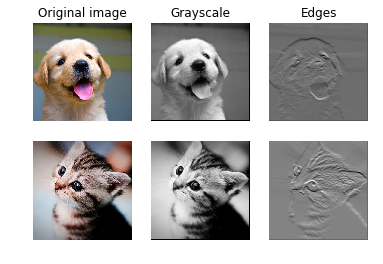

In [4]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, img_size, img_size, 3))
x[0, :, :, :] = imresize(puppy, (img_size, img_size))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

w = np.transpose(w, [2, 3, 1, 0])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, :, :, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, :, :, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, :, :, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, :, :, 1])
plt.show()

# Max-Pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `implementations/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [5]:
# shape is NCHW
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
x = np.transpose(x, [0, 2, 3, 1])

pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])
correct_out = np.transpose(correct_out, [0, 2, 3, 1])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.973812733220958e-08


# Multilayer Convolutional Network

You need to build a convolutional network with tensorflow operations: tf.nn.conv2d, tf.nn.relu, and tf.pool. You may want to do so by modifying the fully connected network provided in this assignment. 



## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [6]:
np.random.seed(15009)

from implementations.conv_net import ConvNet

num_train = 100
X_train = data['X_train'][:num_train].transpose([0, 2, 3, 1])
y_train = data['y_train'][:num_train]
X_val = data['X_val'].transpose([0, 2, 3, 1])
y_val = data['y_val']



model = ConvNet(input_shape=[None, 32, 32, 3],
                filter_shapes=[[3, 3, 3, 5], [3, 3, 5, 5], [3, 3, 5, 5], [3, 3, 5, 2]],
                pooling_schedule=[1, 3],
                fc_hidden_shape=[128, 10])


trace = model.train(X_train, y_train, X_val, y_val,
            learning_rate=1e-3, 
            reg=np.float32(5e-6), 
            num_iters=1000,
            batch_size=20, 
            verbose=True)


iteration 0 / 1000: objective 1661.584595
iteration 100 / 1000: objective 47.931507
iteration 200 / 1000: objective 27.079952
iteration 300 / 1000: objective 17.870882
iteration 400 / 1000: objective 11.173821
iteration 500 / 1000: objective 6.393478
iteration 600 / 1000: objective 3.466872
iteration 700 / 1000: objective 1.911390
iteration 800 / 1000: objective 1.180851
iteration 900 / 1000: objective 0.794648


Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

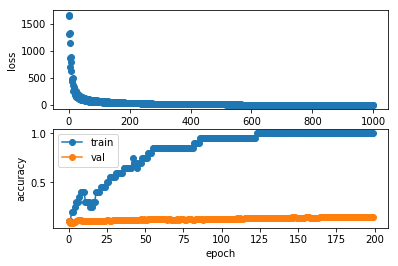

In [7]:
plt.subplot(2, 1, 1)
plt.plot(trace['objective_history'], 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(trace['train_acc_history'], '-o')
plt.plot(trace['val_acc_history'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [8]:
X_train = data['X_train'].transpose([0, 2, 3, 1])
y_train = data['y_train']
X_val = data['X_val'].transpose([0, 2, 3, 1])
y_val = data['y_val']

num_train = X_train.shape[0]
batch_size = 16

model = ConvNet(input_shape=[None, 32, 32, 3], 
                filter_shapes=[[9, 9, 3, 8], [7, 7, 8, 16], [5, 5, 16, 32]], 
                pooling_schedule=[0, 1, 2], 
                fc_hidden_shape=[512, 10],
                use_bn=True)


trace = model.train(X_train, y_train, X_val, y_val,
            learning_rate=1e-3, 
            reg=np.float32(5e-6), 
            num_iters=(num_train * 2 // batch_size + 1),
            batch_size=batch_size, 
            verbose=True)

iteration 0 / 6126: objective 49.204548
iteration 100 / 6126: objective 27.870222
iteration 200 / 6126: objective 35.323536
iteration 300 / 6126: objective 20.680830
iteration 400 / 6126: objective 22.922298
iteration 500 / 6126: objective 32.687088
iteration 600 / 6126: objective 28.680878
iteration 700 / 6126: objective 24.802755
iteration 800 / 6126: objective 21.412701
iteration 900 / 6126: objective 26.212978
iteration 1000 / 6126: objective 34.191166
iteration 1100 / 6126: objective 32.240864
iteration 1200 / 6126: objective 21.071535
iteration 1300 / 6126: objective 25.509996
iteration 1400 / 6126: objective 25.579296
iteration 1500 / 6126: objective 13.873075
iteration 1600 / 6126: objective 25.364075
iteration 1700 / 6126: objective 29.033428
iteration 1800 / 6126: objective 25.096807
iteration 1900 / 6126: objective 20.554745
iteration 2000 / 6126: objective 19.980194
iteration 2100 / 6126: objective 25.050621
iteration 2200 / 6126: objective 19.803610
iteration 2300 / 6126: 

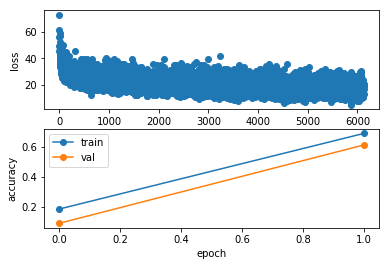

In [9]:
plt.subplot(2, 1, 1)
plt.plot(trace['objective_history'], 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(trace['train_acc_history'], '-o')
plt.plot(trace['val_acc_history'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

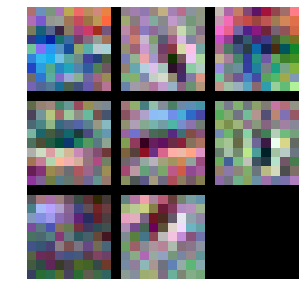

In [10]:
from vis_utils import visualize_grid

grid = visualize_grid(model.ff_layer.transpose(3, 0, 1, 2))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()